# Demonstration of Accelerator Modelling using Python

- [x] cpymad load ISIS model
- [x] cpymad calculate optics at injection point
- [x] pyparticlebunch generate matched bunch and track file 1 turn
- [x] pyparticlebunch dumped file to plot
- [ ] Poincare section
- [ ] Element-by-element tracking 1 turn

#### Import python libraries

In [1]:
import os
from PyParticleBunch import *

#### Run python scripts with useful functions inside 

In [2]:
if os.name=='nt': # Windows
    %run Scripts/helper_functions.py
    %run Scripts/cpymad_helpers.py
else: # Linux    
    %run 'Scripts/helper_functions.py'
    %run 'Scripts/cpymad_helpers.py'

#### Plotting parameters

In [3]:
plt.rcParams['figure.figsize'] = [8.0, 5.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 5

In [4]:
def cpymad_ptc_track_bunchfile(madx_instance, cpymad_logile, sequence_name, bunch_file, turns, observation_list, deltap=None, lossfiles=False):
    madx_instance.use(sequence=sequence_name)   
    
    madx_instance.input('ptc_create_universe;')
    madx_instance.input('ptc_create_layout,model=2,method=2,nst=1,exact,time=true;')
    #madx_instance.input('ptc_create_layout,exact,time=true,model=2,method=2,nst=1;')
    
    if not check_if_file_exists(bunch_file): 
        print('cpymad_ptc_track_bunchfile:: check_if_file_exists returns FALSE. Aborting')
        return False    
    madx_instance.call(file=bunch_file)

    for element in observation_list:
        madx_command = 'ptc_observe, place='+str(element)+';'
        madx_instance.input(madx_command)
    
    # Note deltap is used for icase=5 only   
    if deltap is not None:
        if lossfiles:
            madx_command='ptc_track, turns='+str(int(turns))+', deltap='+str(float(deltap))+', closed_orbit, onetable, icase=5, dump=true, recloss=true, maxaper={1.0, 0.1, 1.0, 0.1, 1000.0, 1.0};'  
        else:
            madx_command='ptc_track, turns='+str(int(turns))+', deltap='+str(float(deltap))+', closed_orbit, onetable, icase=5, dump=true, norm_no=1, maxaper={1000, 1000, 1000, 1000, 1000, 1000};'    

    else:
        if lossfiles:
            madx_command='ptc_track, turns='+str(int(turns))+', closed_orbit, onetable, icase=4, dump=true, recloss=true, maxaper={1.0, 0.1, 1.0, 0.1, 1000.0, 1.0};'  
        else:
            madx_command='ptc_track, turns='+str(int(turns))+', closed_orbit, onetable, icase=4, dump=true, norm_no=1, maxaper={1000, 1000, 1000, 1000, 1000, 1000};'    

    madx_instance.input(madx_command)

    madx_instance.input('ptc_track_end;')
    madx_instance.input('ptc_end;')
    return True

In [5]:
def cpymad_ptc_track_bunchfile_old(madx_instance, cpymad_logile, sequence_name, bunch_file, turns, observation_list, lossfiles=False):
    madx_instance.use(sequence=sequence_name)   
    
    madx_instance.input('ptc_create_universe;')
    madx_instance.input('ptc_create_layout,model=2,method=2,nst=1,exact,time=true;')
    #madx_instance.input('ptc_create_layout,exact,time=true,model=2,method=2,nst=1;')
    
    if not check_if_file_exists(bunch_file): 
        print('cpymad_ptc_track_bunchfile:: check_if_file_exists returns FALSE. Aborting')
        return False    
    madx_instance.call(file=bunch_file)

    for element in observation_list:
        madx_command = 'ptc_observe, place='+str(element)+';'
        madx_instance.input(madx_command)
    
    if lossfiles:
        #madx_command='ptc_track, turns='+str(int(turns))+', closed_orbit, onetable, icase=5, dump=true, recloss=true, maxaper={0.1, 0.01, 0.1, 0.01, 1.0, 0.1};'  
        madx_command='ptc_track, turns='+str(int(turns))+', closed_orbit, onetable, icase=4, dump=true, recloss=true, maxaper={1.0, 0.1, 1.0, 0.1, 1000.0, 1.0};'  
    else:
        #madx_command='ptc_track, turns='+str(int(turns))+', closed_orbit, onetable, icase=5, dump=true;'    
        # Note deltap is used for icase=5 only
        madx_command='ptc_track, deltap=0.001, turns='+str(int(turns))+', closed_orbit, onetable, icase=4, dump=true, norm_no=1, maxaper={1000, 1000, 1000, 1000, 1000, 1000};'    
    madx_instance.input(madx_command)

    madx_instance.input('ptc_track_end;')
    madx_instance.input('ptc_end;')
    return True

In [6]:
def cpymad_ptc_tracktable_to_dframe_multiple_turns(tracked_file, start_element, end_element):
    if not check_if_file_exists(tracked_file):
        print('cpymad_tracktable_to_files::ERROR: Input file not found')
        return False
    
    # empty dataframe with column names and expected types
    df = pnd.DataFrame({c: pnd.Series(dtype=t) for c, t in {'ID': 'int', 'turn': 'int', 'x': 'float', 'px': 'float', 'y': 'float', 'py': 'float', 't': 'float', 'pt': 'float', 's': 'float', 'e': 'float'}.items()})
    df_final = pnd.DataFrame({c: pnd.Series(dtype=t) for c, t in {'ID': 'int', 'turn': 'int', 'x': 'float', 'px': 'float', 'y': 'float', 'py': 'float', 't': 'float', 'pt': 'float', 's': 'float', 'e': 'float'}.items()})
    
    infile = open(tracked_file)
    linelist = infile.readlines()
    file_len = len(linelist)  
    turn_counter = 0
    
    for i in range(0,file_len,1):
        line = linelist[i]
        if line.startswith('@'): pass
        elif line.startswith('*'): pass
        elif line.startswith('$'): pass
        elif line.startswith('#segment'): 
            if (start_element in line) or (end_element in line):        
                turn_counter +=1
                ignore_flag = False
            else:
                ignore_flag = True
        else:
            if ignore_flag: pass
            else:                
                new_row = {'ID': int(float(line.split()[0])), 'turn': int(float(line.split()[1])), 'x': (float(line.split()[2])), 'px': (float(line.split()[3])), 'y': (float(line.split()[4])), 'py': (float(line.split()[5])), 't': (float(line.split()[6])), 'pt': (float(line.split()[7])), 's': (float(line.split()[8])), 'e': (float(line.split()[9]))}
                df_final = df_final.append(new_row, ignore_index=True) 
            
                #df[int(float(line.split()[0]))] = [int(float(line.split()[1])), float(line.split()[2]), float(line.split()[3]), float(line.split()[4]), float(line.split()[5]),float(line.split()[6]), float(line.split()[7]), float(line.split()[8]), float(line.split()[9])]
                #pnd.concat([df, df_final])
                
    df_new = df_final[df_final['x'].notna()]
    df_new = df_new[df_new['y'].notna()]
    
    return df_new      
    

## cpymad: generate and track bunch

#### Start the cpymad program

In [7]:
save_folder = 'cpymad_output/'
make_directory(save_folder)
plot_folder = 'Plots/'
make_directory(plot_folder)
output_line = 0

cpymad_logfile = save_folder + 'cpymad_logfile.log'
madx = cpymad_start(cpymad_logfile)

Directory cpymad_output/ exists
Directory Plots/ exists


#### Load ISIS lattice files

In [8]:
master_lattice_dir = 'ISIS_Lattice/'

#madx.input('beam,gamma=(1.2+0.938256)/.938256,particle=proton;') #AR
madx.call(file=master_lattice_dir+'ISIS.injected_beam')
#madx.call(file=master_lattice_dir+'ISIS.extracted_beam')
madx.call(file=master_lattice_dir+'ISIS.elements')
madx.call(file=master_lattice_dir+'ISIS.strength')
madx.call(file=master_lattice_dir+'ISIS.sequence')
sequence_name = 'synchrotron'

#### Perform cpymad TWISS - calculate lattice optics, store info in TWISS table

In [9]:
twiss_0_file = str(save_folder+'twiss_0.tfs')
twiss_0 = cpymad_madx_twiss(madx, cpymad_logfile, sequence_name, twiss_0_file)

Sequence synchrotron exists in this instance of MAD-X. Active sequences:
{'synchrotron': <Sequence: synchrotron>}


/home/HR/Repositories/work_experience_2022/02_Demo/Scripts/cpymad_helpers.py:1007: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  f2_ax4.set_ylim(co_min,co_max)
/home/HR/Repositories/work_experience_2022/02_Demo/Scripts/cpymad_helpers.py:1008: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  f2_ax3.set_ylim(co_min,co_max)


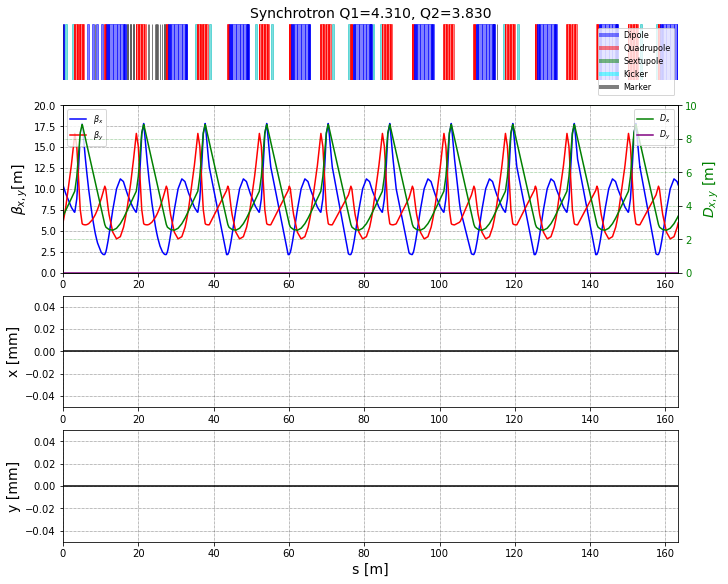

In [10]:
cpymad_plot_CO(madx, twiss_0, 'Synchrotron', (save_folder +'CO_0.png'))

#### Perform cpymad Survey - plot lattice elements in real space

In [11]:
madx.survey()
mySurvey=madx.table.survey.dframe()

In [12]:
mySurvey

,name,keyword,s,l,angle,x,y,z,theta,phi,psi,globaltilt,tilt,slot_id,assembly_id,mech_sep,v_pos,comments
#s,synchrotron$start,marker,0.00000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
sp0_datum,sp0_datum,marker,0.00000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
sp0_dipfr8,sp0_dipfr8,sbend,0.16000,0.16,0.007026,-0.000562,0.0,0.159999,-0.007026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
sp0_dipfr9,sp0_dipfr9,sbend,0.36000,0.20,0.001126,-0.002080,0.0,0.359993,-0.008152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
sp0_dipfr10,sp0_dipfr10,sbend,0.39000,0.03,0.000097,-0.002326,0.0,0.389992,-0.008249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp9_dip6,sp9_dip6,sbend,163.12282,0.06,0.008568,-0.000328,0.0,-0.229436,-6.257577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
sp9_dipfr6,sp9_dipfr6,sbend,163.32282,0.20,0.024266,0.002367,0.0,-0.029459,-6.281843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
sp9_dipfr7,sp9_dipfr7,sbend,163.36282,0.04,0.001757,0.002386,0.0,0.010541,-6.283600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
sp9_end,sp9_end,marker,163.36282,0.00,0.000000,0.002386,0.0,0.010541,-6.283600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,


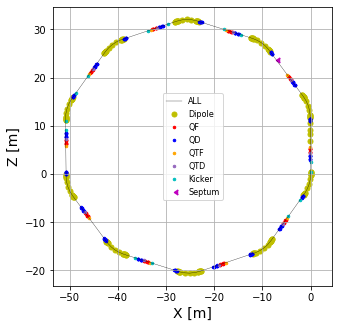

In [13]:
# Plot quads and sbends only
kSurvey=mySurvey[mySurvey['keyword'].str.contains('kicker')]
qfSurvey=mySurvey[mySurvey['name'].str.contains('qf')]
qtfSurvey=mySurvey[mySurvey['name'].str.contains('qtf')]
qdSurvey=mySurvey[mySurvey['name'].str.contains('qd')]
qtdSurvey=mySurvey[mySurvey['name'].str.contains('qtd')]
mbSurvey=mySurvey[mySurvey['name'].str.contains('dip')]
SepSurvey=mySurvey[mySurvey['name'].str.contains('sep')]

fig = plt.figure(facecolor='w', edgecolor='k', figsize=[5.0, 8.0])
plt.plot(mySurvey.x,mySurvey.z,'-k', lw=0.3, label='ALL')
plt.scatter(mbSurvey.x,mbSurvey.z, marker='o', color='y', label='Dipole')
mtype='.'
plt.scatter(qfSurvey.x,qfSurvey.z, marker=mtype, color='r', label='QF')
plt.scatter(qdSurvey.x,qdSurvey.z, marker=mtype, color='b', label='QD')
plt.scatter(qtfSurvey.x,qtfSurvey.z, marker=mtype, color='orange', label='QTF')
plt.scatter(qtdSurvey.x,qtdSurvey.z, marker=mtype, color='tab:purple', label='QTD')
plt.scatter(kSurvey.x,kSurvey.z, marker=mtype, color='c', label='Kicker')
plt.scatter(SepSurvey.x,SepSurvey.z, marker=4, color='m', label='Septum')

plt.legend()

# Custom legend
#legend_elements = [Line2D([0], [0], color='y', label='Dipole'), Line2D([0], [0], color='g', label='QD'), Line2D([0], [0], color='b', label='QF')]
#plt.legend(handles=legend_elements, loc=1)

plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()

savename = save_folder + 'Survey.png'
plt.savefig(savename, bbox_inches='tight')

#### Generate matched distribution using pyparticle bunch library 

In [14]:
beta_x = twiss_0.betx[0]
beta_y = twiss_0.bety[0]
alpha_x =  twiss_0.alfx[0]
alpha_y =  twiss_0.alfy[0]
D_x =  twiss_0.dx[0]
D_xp = twiss_0.dpx[0]
D_y = twiss_0.dy[0]
D_yp = twiss_0.dpy[0]
emittance_x = emittance_y = 400 * 1E-6
x_limit = 5
y_limit = 5
n = 1E5

In [15]:
Matched_Gaussian_4D_bunch = ParticleBunch.MatchedGaussian_4D(n, emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y, x_limit = 5, y_limit = 5)

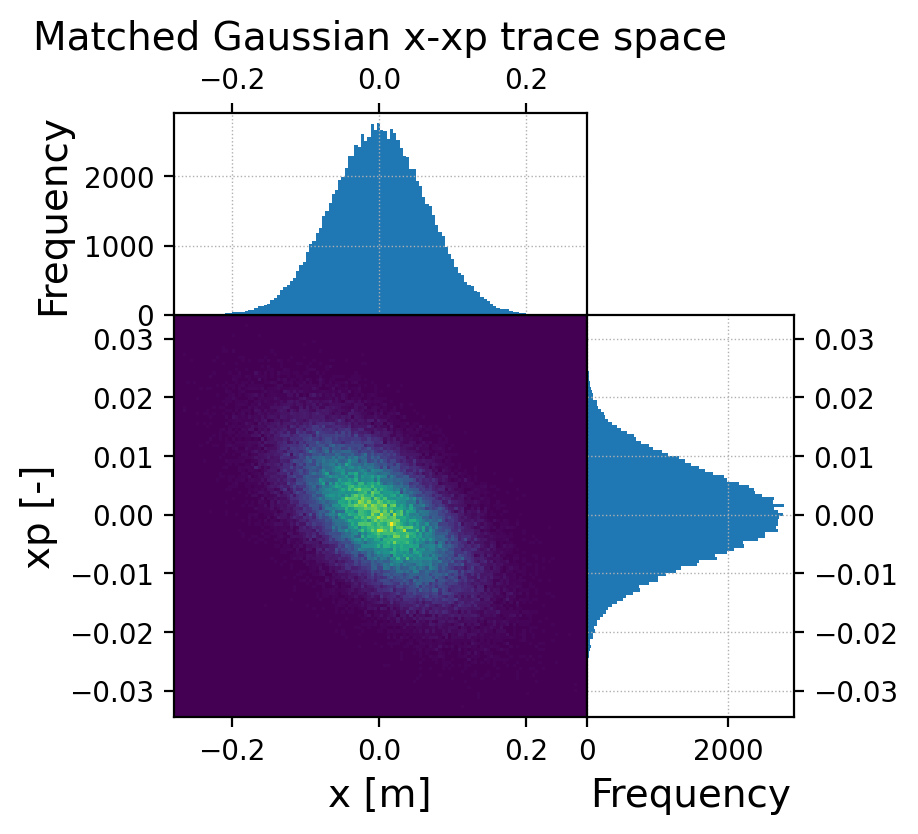

In [16]:
Matched_Gaussian_4D_bunch.plot_heatmap('x', 'xp', plot_folder+'Matched_Gaussian_4D_x_trace_space.png', 'Matched Gaussian x-xp trace space')

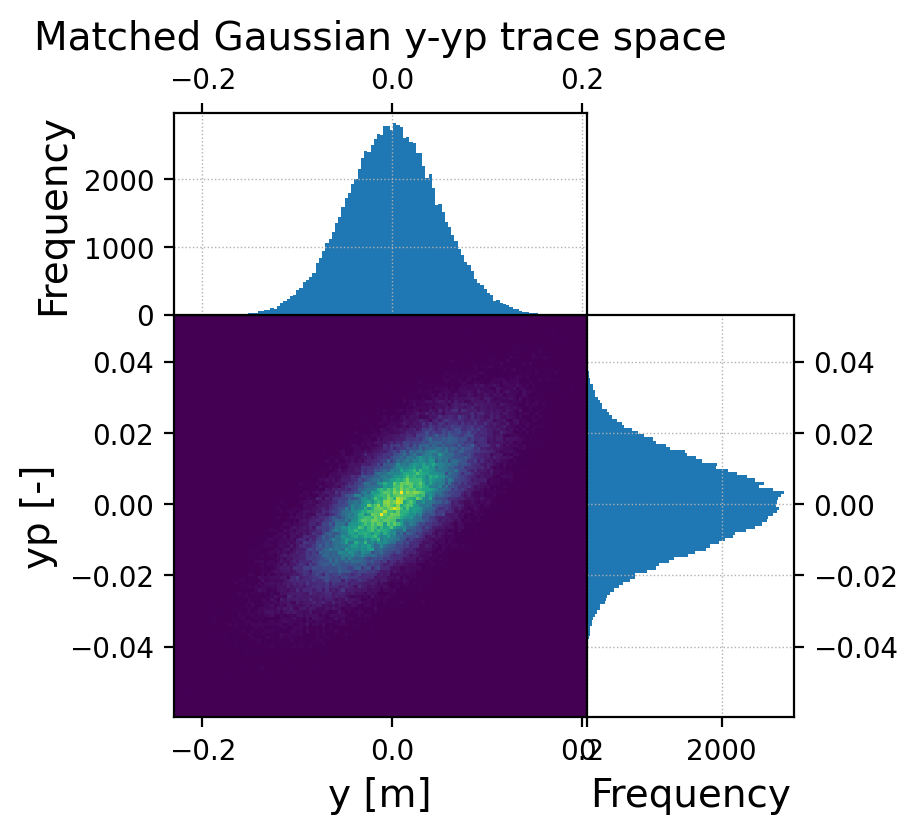

In [17]:
Matched_Gaussian_4D_bunch.plot_heatmap('y', 'yp', plot_folder+'Matched_Gaussian_4D_y_trace_space.png', 'Matched Gaussian y-yp trace space')

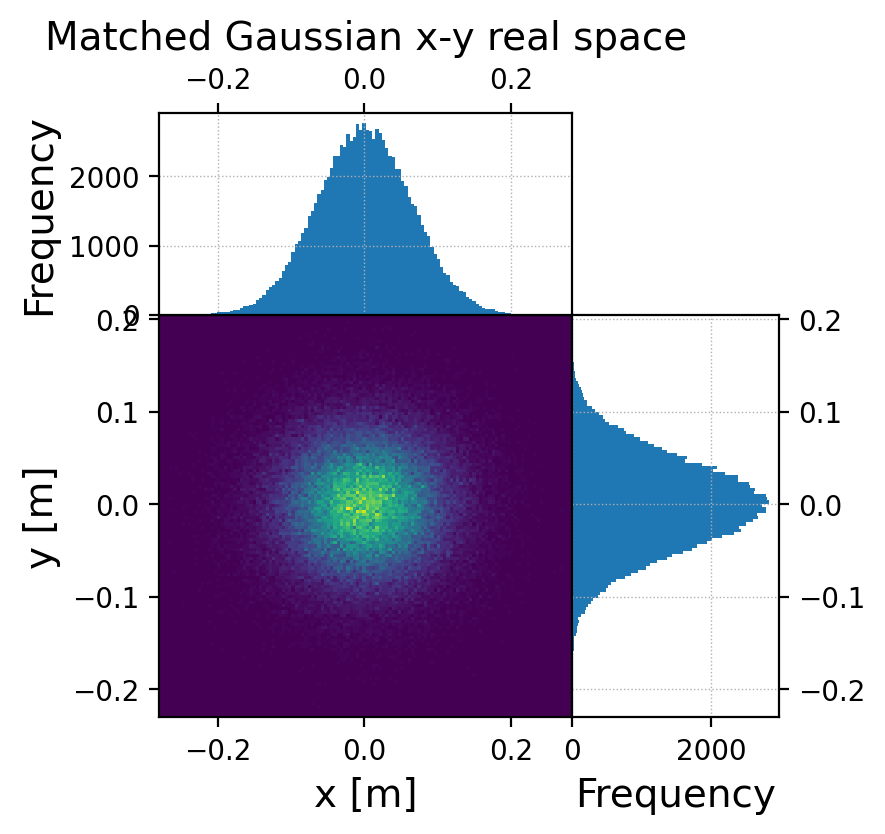

In [18]:
Matched_Gaussian_4D_bunch.plot_heatmap('x', 'y', plot_folder+'Matched_Gaussian_4D_real_space.png', 'Matched Gaussian x-y real space')

In [19]:
Matched_Gaussian_4D_bunch_Filename = 'Matched_Gaussian_4D_Bunch.ptc'
Matched_Gaussian_4D_bunch.print_PTC_file(Matched_Gaussian_4D_bunch_Filename)

#### Track 1 turn 

In [20]:
observation_list = []
track_turns = 1
cpymad_ptc_track_bunchfile(madx, cpymad_logfile, 'Synchrotron', Matched_Gaussian_4D_bunch_Filename, track_turns, observation_list, None, False)

Matched_Gaussian_4D_Bunch.ptc  exists


True

In [21]:
df_trackone = cpymad_ptc_tracktable_to_dframe_multiple_turns('trackone', 'end', 'end')

trackone  exists


In [22]:
df_trackone

,ID,turn,x,px,y,py,t,pt,s,e
0,1.0,1.0,-0.022674,0.003038,-0.022293,-0.022508,0.0,0.0,163.36282,1.008712
1,2.0,1.0,-0.029186,-0.002040,0.059033,0.010145,0.0,0.0,163.36282,1.008712
2,3.0,1.0,0.127987,-0.013564,-0.050461,-0.005655,0.0,0.0,163.36282,1.008712
3,4.0,1.0,-0.003708,-0.002374,0.031502,0.007887,0.0,0.0,163.36282,1.008712
4,5.0,1.0,0.055073,0.002051,-0.074573,-0.005175,0.0,0.0,163.36282,1.008712
...,...,...,...,...,...,...,...,...,...,...
99995,99996.0,1.0,0.016128,0.005425,0.057559,0.009975,0.0,0.0,163.36282,1.008712
99996,99997.0,1.0,-0.060554,0.006667,0.016927,0.005203,0.0,0.0,163.36282,1.008712
99997,99998.0,1.0,-0.185172,0.020782,-0.013402,0.003370,0.0,0.0,163.36282,1.008712
99998,99999.0,1.0,0.080827,-0.008300,0.038741,-0.001967,0.0,0.0,163.36282,1.008712


In [23]:
df_trackone = pandas_lowercase_all_strings(df_trackone)

In [24]:
pandas_save_to_file(df_trackone, 'df_trackone.dat')

In [25]:
Matched_Gaussian_4D_bunch_1_turn = ParticleBunch.from_tracked_df(df_trackone)

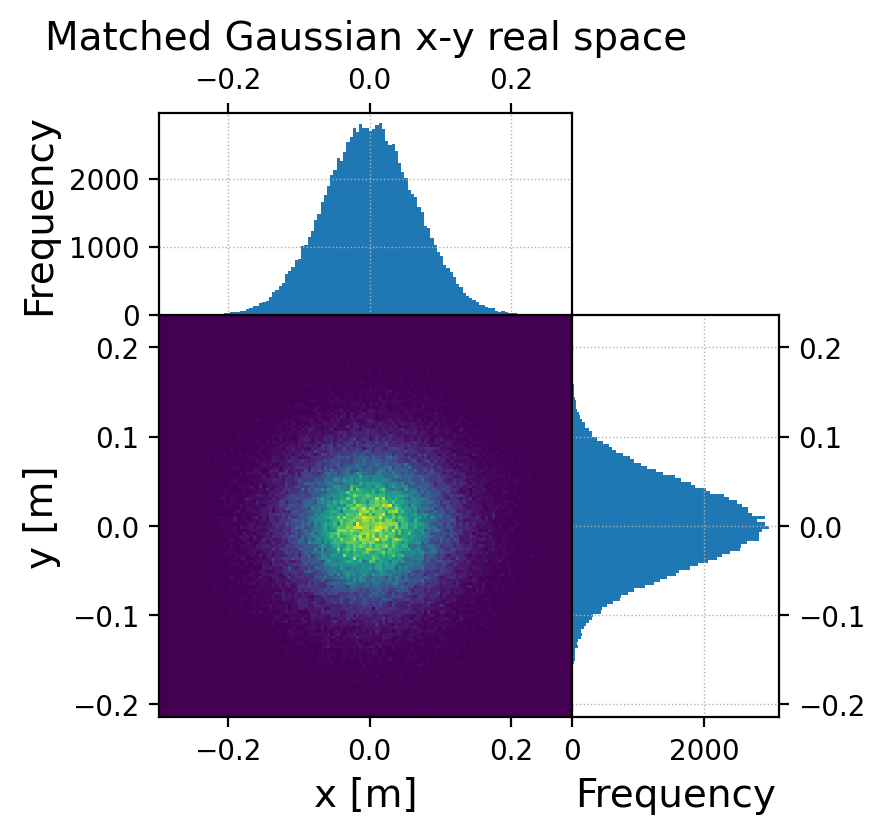

In [26]:
Matched_Gaussian_4D_bunch_1_turn.plot_heatmap('x', 'y', plot_folder+'1_turn_real_space.png', 'Matched Gaussian x-y real space')

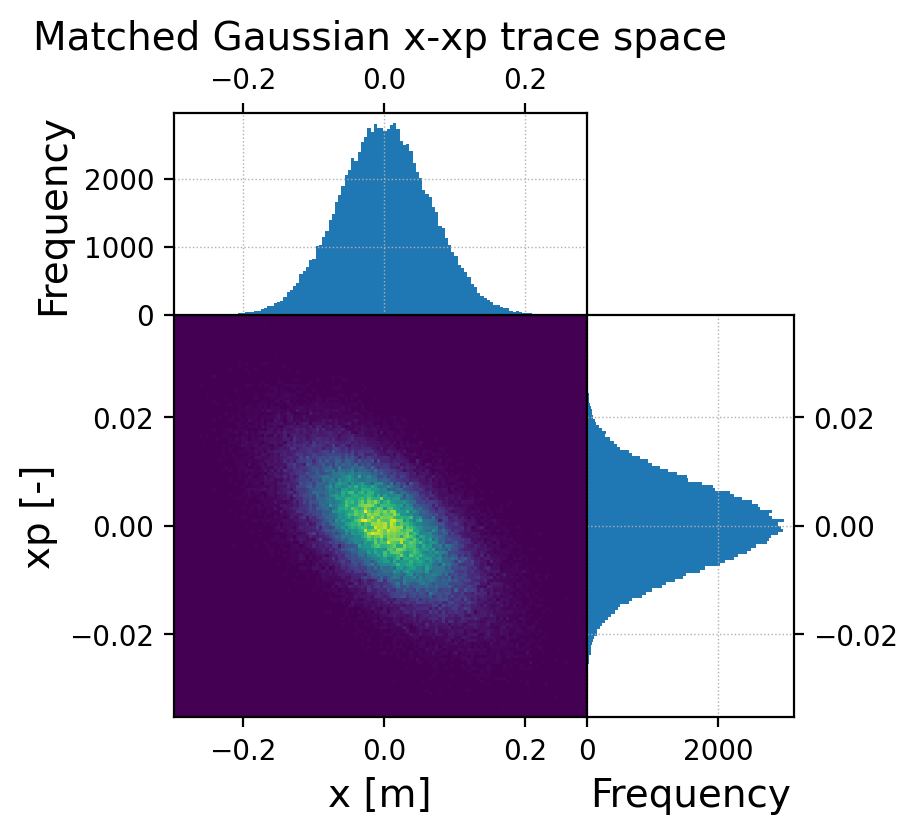

In [27]:
Matched_Gaussian_4D_bunch_1_turn.plot_heatmap('x', 'xp', plot_folder+'1_turn_x_trace_space.png', 'Matched Gaussian x-xp trace space')

#### End this cpymad run

In [28]:
madx.quit()

## cpymad: Poincare Sections

#### Start the cpymad program

In [29]:
output_line = 0

cpymad_logfile = save_folder + 'cpymad_logfile.log'
madx = cpymad_start(cpymad_logfile)

#### Load ISIS lattice files

In [30]:
master_lattice_dir = 'ISIS_Lattice/'

#madx.input('beam,gamma=(1.2+0.938256)/.938256,particle=proton;') #AR
madx.call(file=master_lattice_dir+'ISIS.injected_beam')
#madx.call(file=master_lattice_dir+'ISIS.extracted_beam')
madx.call(file=master_lattice_dir+'ISIS.elements')
madx.call(file=master_lattice_dir+'ISIS.strength')
madx.call(file=master_lattice_dir+'ISIS.sequence')
sequence_name = 'synchrotron'

#### Perform cpymad TWISS - calculate lattice optics, store info in TWISS table

In [31]:
twiss_0_file = str(save_folder+'twiss_0.tfs')
twiss_0 = cpymad_madx_twiss(madx, cpymad_logfile, sequence_name, twiss_0_file)

Sequence synchrotron exists in this instance of MAD-X. Active sequences:
{'synchrotron': <Sequence: synchrotron>}


/home/HR/Repositories/work_experience_2022/02_Demo/Scripts/cpymad_helpers.py:1007: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  f2_ax4.set_ylim(co_min,co_max)
/home/HR/Repositories/work_experience_2022/02_Demo/Scripts/cpymad_helpers.py:1008: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  f2_ax3.set_ylim(co_min,co_max)


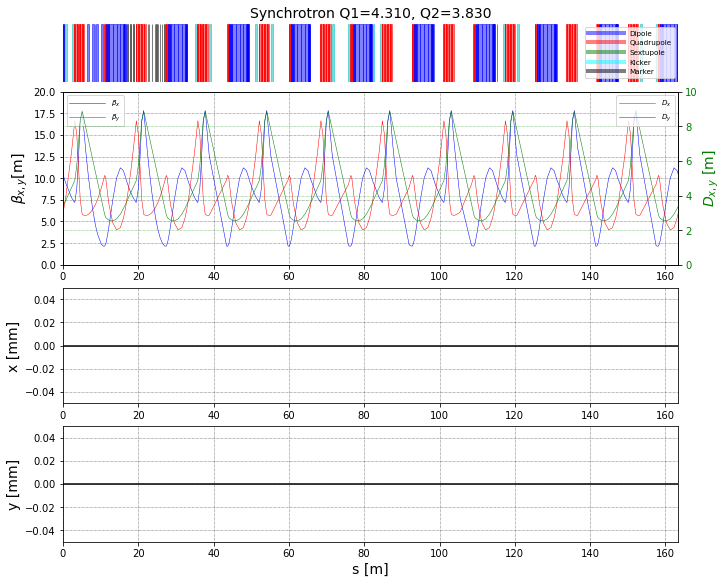

In [32]:
cpymad_plot_CO(madx, twiss_0, 'Synchrotron', (save_folder +'CO_0.png'))

#### Generate matched Poincare distribution

In [33]:
beta_x = twiss_0.betx[0]
beta_y = twiss_0.bety[0]
alpha_x =  twiss_0.alfx[0]
alpha_y =  twiss_0.alfy[0]
D_x =  twiss_0.dx[0]
D_xp = twiss_0.dpx[0]
D_y = twiss_0.dy[0]
D_yp = twiss_0.dpy[0]
emittance_x = emittance_y = 400 * 1E-6
min_sig = 0
max_sig = 15
n_mp = 30
co_x = twiss_0.x[0]
deltap = 0.0 # 0.01
coord = 'x'

In [34]:
PoincareBunch_H = ParticleBunch.Poincare_1D(n_mp, coord, emittance_x, alpha_x, beta_x, min_sig, max_sig, co_x, deltap, dispersion = D_x)

x


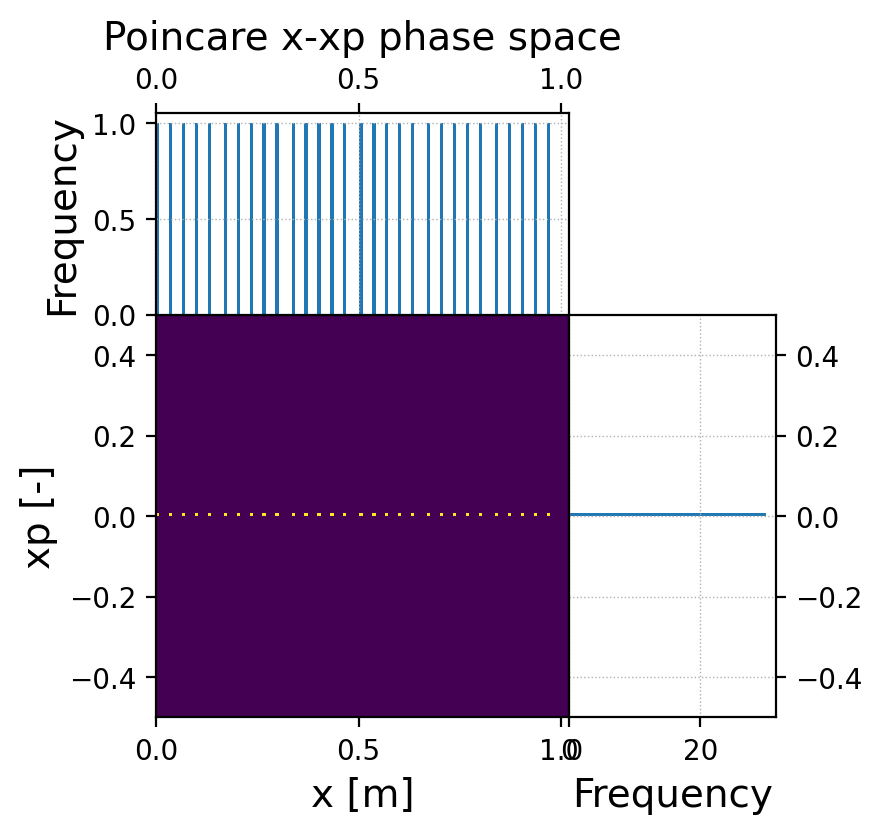

In [35]:
PoincareBunch_H.plot_heatmap('x', 'xp', 'Plots/PoincareBunch_H_x_phase_space.png','Poincare x-xp phase space')

In [36]:
PoincareBunch_Filename = 'Poincare_H_Bunch.ptc'
PoincareBunch_H.print_PTC_file(PoincareBunch_Filename)

In [37]:
observation_list = []
turns = 1024
cpymad_ptc_track_bunchfile(madx, cpymad_logfile, sequence_name, PoincareBunch_Filename, turns, observation_list, None, False)

Poincare_H_Bunch.ptc  exists


True

In [38]:
df_trackone_poincare_h = cpymad_ptc_tracktable_to_dframe_multiple_turns('trackone', 'end', 'end')

trackone  exists


In [39]:
df_trackone_poincare_h = pandas_lowercase_all_strings(df_trackone_poincare_h)

In [40]:
df_trackone_poincare_h['x_norm'] = df_trackone_poincare_h.x/np.sqrt(twiss_0.betx[0])
df_trackone_poincare_h['px_norm'] = ((df_trackone_poincare_h.x*twiss_0.alfx[0])/np.sqrt(twiss_0.betx[0])) + np.sqrt(twiss_0.betx[0])*df_trackone_poincare_h.px
df_trackone_poincare_h['y_norm'] = df_trackone_poincare_h.y/np.sqrt(twiss_0.bety[0])
df_trackone_poincare_h['py_norm'] = ((df_trackone_poincare_h.y*twiss_0.alfy[0])/np.sqrt(twiss_0.bety[0])) + np.sqrt(twiss_0.bety[0])*df_trackone_poincare_h.py

In [41]:
df_trackone_poincare_h

,id,turn,x,px,y,py,t,pt,s,e,x_norm,px_norm,y_norm,py_norm
0,1.0,1.0,-0.000000,0.000000,0.0,0.0,0.0,0.0,163.36282,1.008712,-0.000000,0.000000,0.0,0.0
1,2.0,1.0,0.007558,-0.004516,0.0,0.0,0.0,0.0,163.36282,1.008712,0.002334,-0.012876,0.0,0.0
2,3.0,1.0,0.014938,-0.009062,0.0,0.0,0.0,0.0,163.36282,1.008712,0.004612,-0.025892,0.0,0.0
3,4.0,1.0,0.021814,-0.013615,0.0,0.0,0.0,0.0,163.36282,1.008712,0.006735,-0.039047,0.0,0.0
4,5.0,1.0,0.027850,-0.018150,0.0,0.0,0.0,0.0,163.36282,1.008712,0.008599,-0.052337,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27646,23.0,1024.0,-0.910517,0.004794,0.0,0.0,0.0,0.0,163.36282,1.008712,-0.281145,-0.195142,0.0,0.0
27647,24.0,1024.0,0.409177,-0.119543,0.0,0.0,0.0,0.0,163.36282,1.008712,0.126344,-0.292480,0.0,0.0
27648,25.0,1024.0,0.966029,-0.090181,0.0,0.0,0.0,0.0,163.36282,1.008712,0.298286,-0.068549,0.0,0.0
27649,26.0,1024.0,0.810177,-0.125129,0.0,0.0,0.0,0.0,163.36282,1.008712,0.250163,-0.217791,0.0,0.0


In [42]:
pandas_save_to_file(df_trackone_poincare_h, 'df_trackone_poincare_h.dat')

In [43]:
df_new = df_trackone_poincare_h

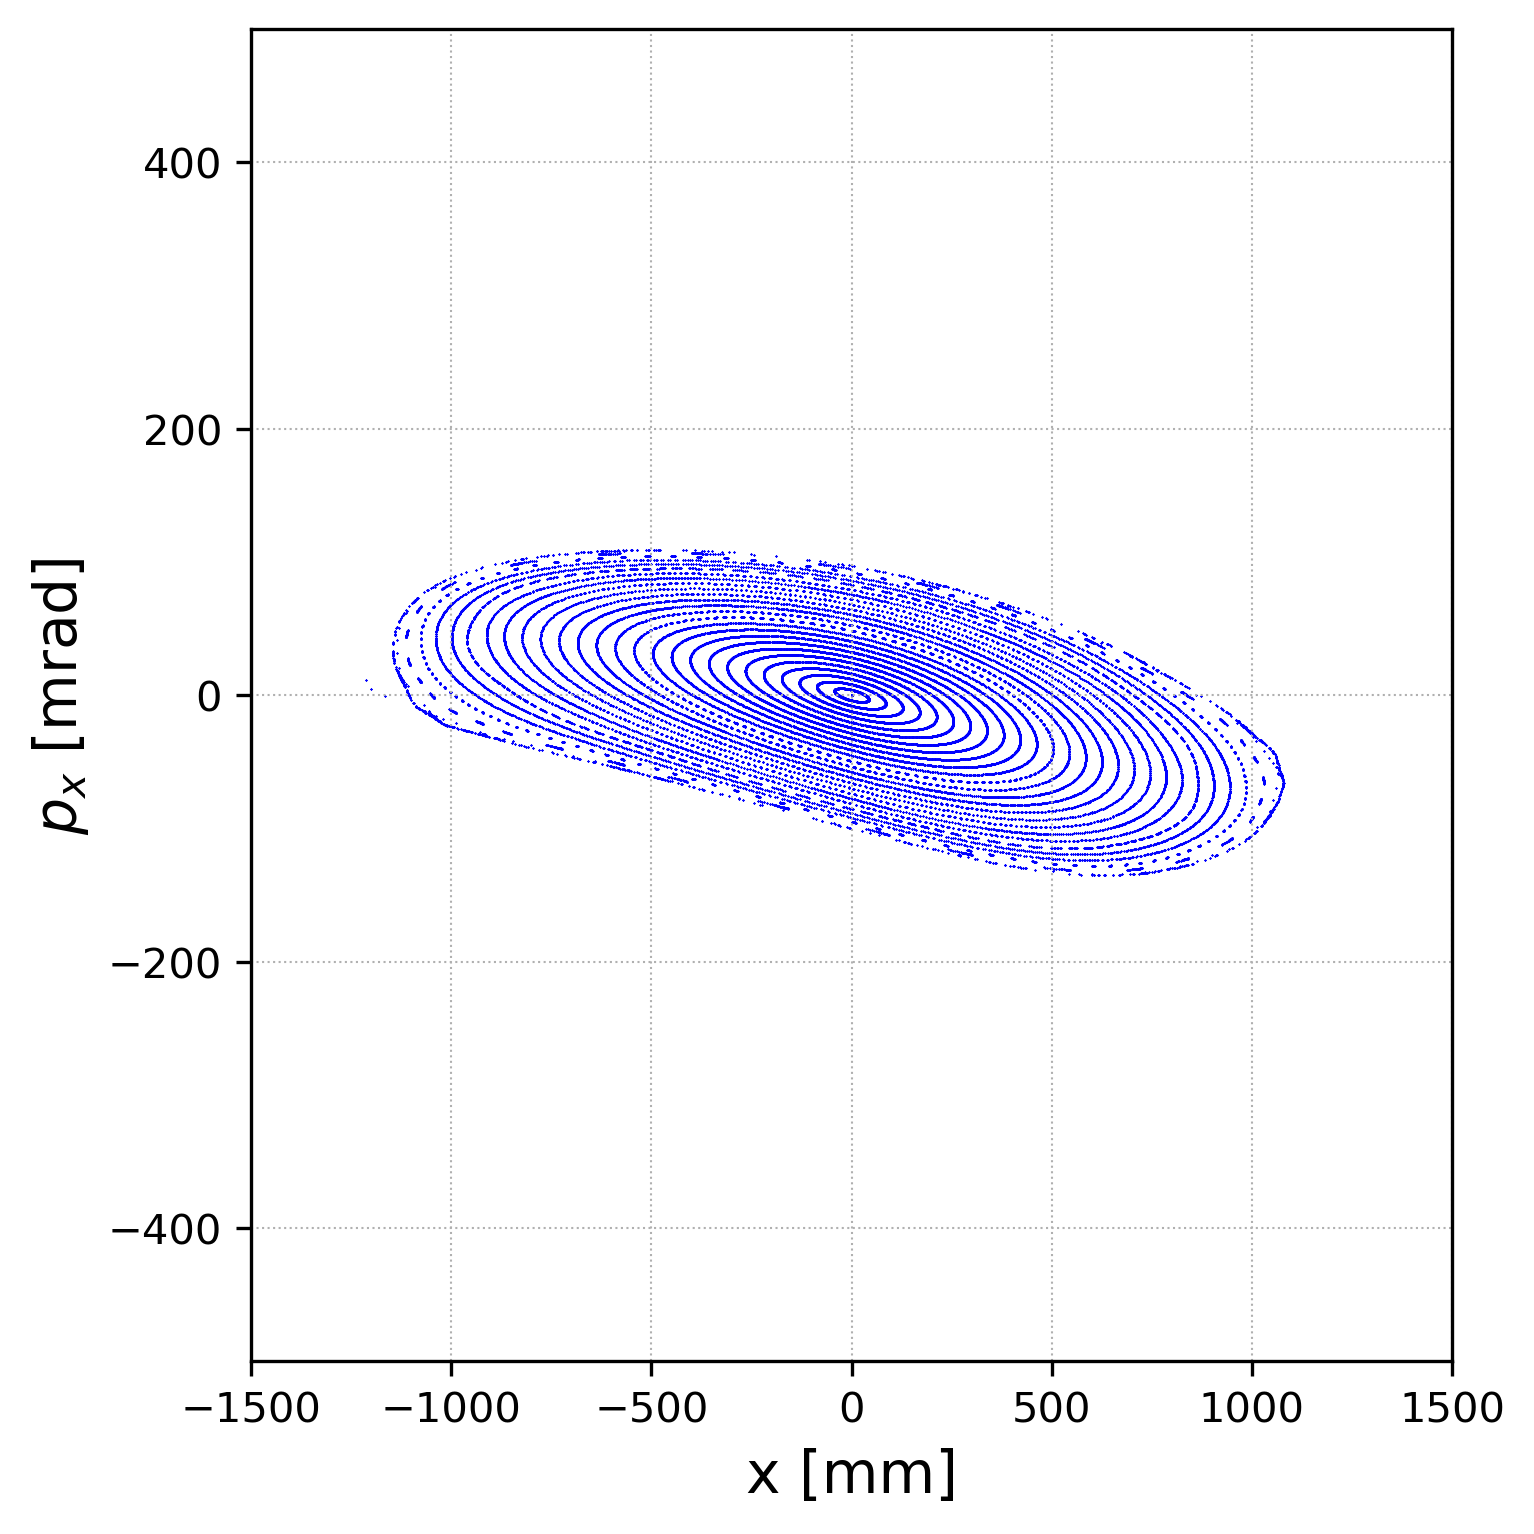

In [44]:
heights = [1]
fig1 = plt.figure(figsize=(5,5),facecolor='w', edgecolor='k',constrained_layout=True, dpi=300)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1, height_ratios=heights)
multi = 1E3

f1_ax1 = fig1.add_subplot(spec[0])  
f1_ax1.scatter(df_new['x']*multi, df_new['px']*multi, marker='x', color='b')
f1_ax1.set_xlabel('x [mm]')
f1_ax1.set_ylabel(r'$p_{x}$ [mrad]')
f1_ax1.grid(which='both', ls=':', lw=0.5)

f1_ax1.set_xlim([-1500, 1500])
f1_ax1.set_ylim([-500, 500])


savefile = plot_folder + 'Poincare_Section_H_1024.png'
fig1.savefig(savefile, bbox_inches='tight');

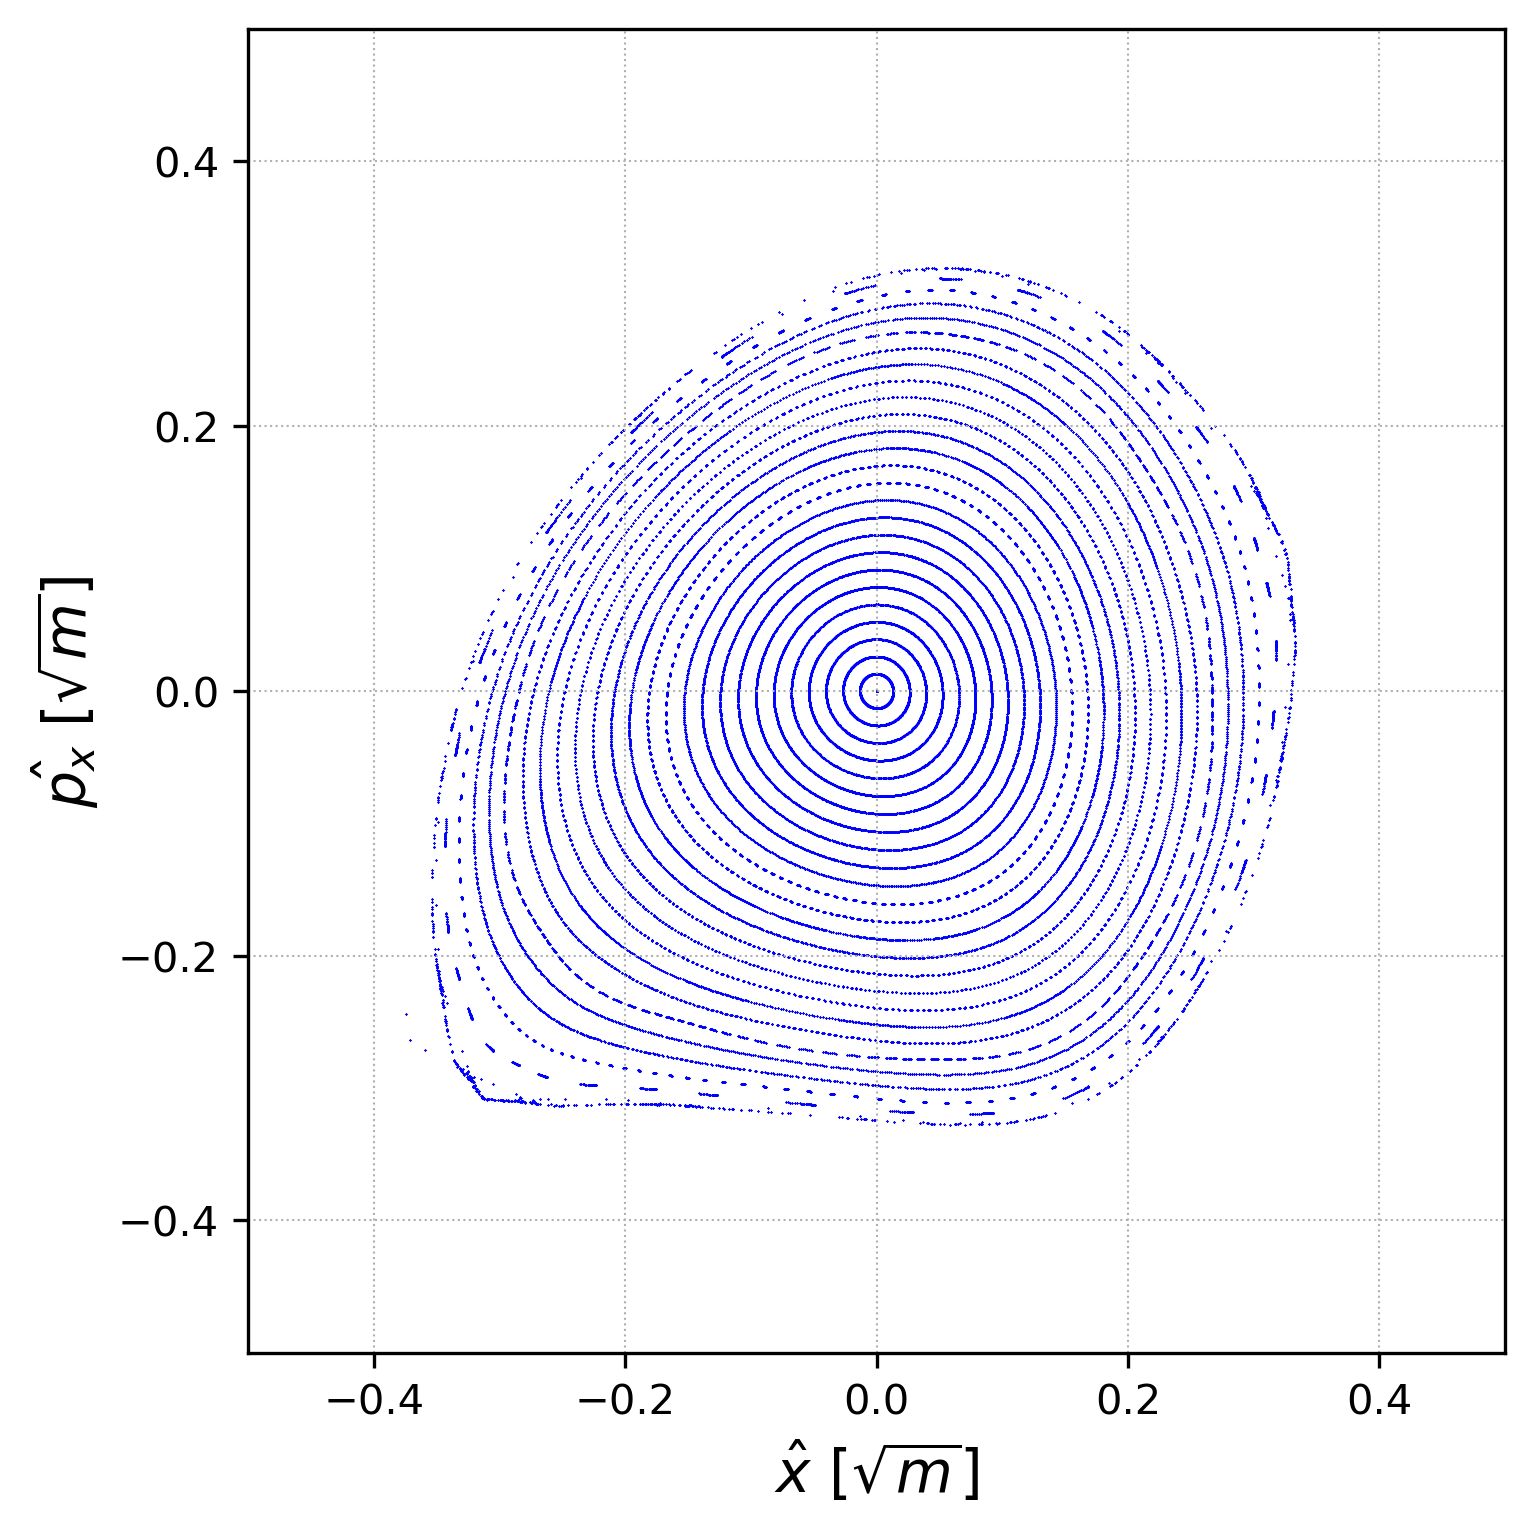

In [45]:
heights = [1]
fig1 = plt.figure(figsize=(5,5),facecolor='w', edgecolor='k',constrained_layout=True, dpi=300)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1, height_ratios=heights)
multi = 1

f1_ax1 = fig1.add_subplot(spec[0])  
f1_ax1.scatter(df_new['x_norm']*multi, df_new['px_norm']*multi, marker='x', color='b')
f1_ax1.set_xlabel(r'$\hat{x}$ [$\sqrt{m}$]')
f1_ax1.set_ylabel(r'$\hat{p_{x}}$ [$\sqrt{m}$]')
f1_ax1.grid(which='both', ls=':', lw=0.5)

f1_ax1.set_xlim([-0.5, 0.5])
f1_ax1.set_ylim([-0.5, 0.5])

savefile = plot_folder + 'Poincare_Section_H_1024_norm.png'
fig1.savefig(savefile, bbox_inches='tight');

#### Add a momentum spread

In [46]:
beta_x = twiss_0.betx[0]
beta_y = twiss_0.bety[0]
alpha_x =  twiss_0.alfx[0]
alpha_y =  twiss_0.alfy[0]
D_x =  twiss_0.dx[0]
D_xp = twiss_0.dpx[0]
D_y = twiss_0.dy[0]
D_yp = twiss_0.dpy[0]
emittance_x = emittance_y = 400 * 1E-6
min_sig = 0
max_sig = 15
n_mp = 30
co_x = twiss_0.x[0]
deltap = 0.01 # 0.01
coord = 'x'

In [47]:
PoincareBunch_H_dp = ParticleBunch.Poincare_1D(n_mp, coord, emittance_x, alpha_x, beta_x, min_sig, max_sig, co_x, deltap, dispersion = D_x)

x


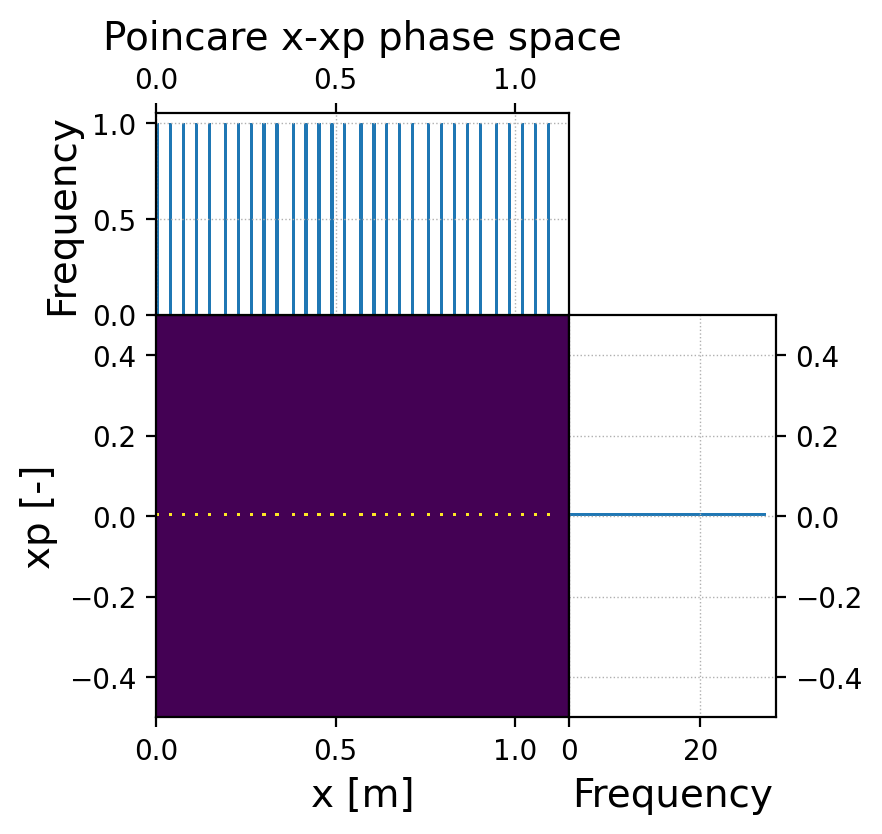

In [48]:
PoincareBunch_H_dp.plot_heatmap('x', 'xp', 'Plots/PoincareBunch_H_dp_x_phase_space.png','Poincare x-xp phase space')

In [49]:
PoincareBunch_H_dp_Filename = 'Poincare_H_dp_Bunch.ptc'
PoincareBunch_H_dp.print_PTC_file(PoincareBunch_H_dp_Filename)

In [50]:
observation_list = []
turns = 1024
cpymad_ptc_track_bunchfile(madx, cpymad_logfile, sequence_name, PoincareBunch_Filename, turns, observation_list, deltap, lossfiles=False)

Poincare_H_Bunch.ptc  exists


True

In [51]:
df_trackone_poincare_h = cpymad_ptc_tracktable_to_dframe_multiple_turns('trackone', 'end', 'end')

trackone  exists


In [52]:
df_trackone_poincare_h_dp = pandas_lowercase_all_strings(df_trackone_poincare_h)

In [53]:
df_trackone_poincare_h_dp['x_norm'] = df_trackone_poincare_h_dp.x/np.sqrt(twiss_0.betx[0])
df_trackone_poincare_h_dp['px_norm'] = ((df_trackone_poincare_h_dp.x*twiss_0.alfx[0])/np.sqrt(twiss_0.betx[0])) + np.sqrt(twiss_0.betx[0])*df_trackone_poincare_h_dp.px
df_trackone_poincare_h_dp['y_norm'] = df_trackone_poincare_h_dp.y/np.sqrt(twiss_0.bety[0])
df_trackone_poincare_h_dp['py_norm'] = ((df_trackone_poincare_h_dp.y*twiss_0.alfy[0])/np.sqrt(twiss_0.bety[0])) + np.sqrt(twiss_0.bety[0])*df_trackone_poincare_h_dp.py

In [54]:
df_trackone_poincare_h_dp

,id,turn,x,px,y,py,t,pt,s,e,x_norm,px_norm,y_norm,py_norm
0,1.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,163.36282,1.008712,0.000000,0.000000,0.0,0.0
1,2.0,1.0,0.019587,-0.005242,0.0,0.0,0.0,0.0,163.36282,1.008712,0.006048,-0.012446,0.0,0.0
2,3.0,1.0,0.038974,-0.010543,0.0,0.0,0.0,0.0,163.36282,1.008712,0.012034,-0.025127,0.0,0.0
3,4.0,1.0,0.057903,-0.015891,0.0,0.0,0.0,0.0,163.36282,1.008712,0.017879,-0.038066,0.0,0.0
4,5.0,1.0,0.076107,-0.021271,0.0,0.0,0.0,0.0,163.36282,1.008712,0.023500,-0.051280,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28674,24.0,1024.0,-0.330958,-0.067623,0.0,0.0,0.0,0.0,163.36282,1.008712,-0.102192,-0.295577,0.0,0.0
28675,25.0,1024.0,-0.268289,0.107457,0.0,0.0,0.0,0.0,163.36282,1.008712,-0.082841,0.285937,0.0,0.0
28676,26.0,1024.0,-1.116065,0.075286,0.0,0.0,0.0,0.0,163.36282,1.008712,-0.344613,-0.014404,0.0,0.0
28677,27.0,1024.0,0.761347,0.022584,0.0,0.0,0.0,0.0,163.36282,1.008712,0.235085,0.249295,0.0,0.0


In [55]:
pandas_save_to_file(df_trackone_poincare_h_dp, 'df_trackone_poincare_h_dp.dat')

In [56]:
df_new = df_trackone_poincare_h_dp

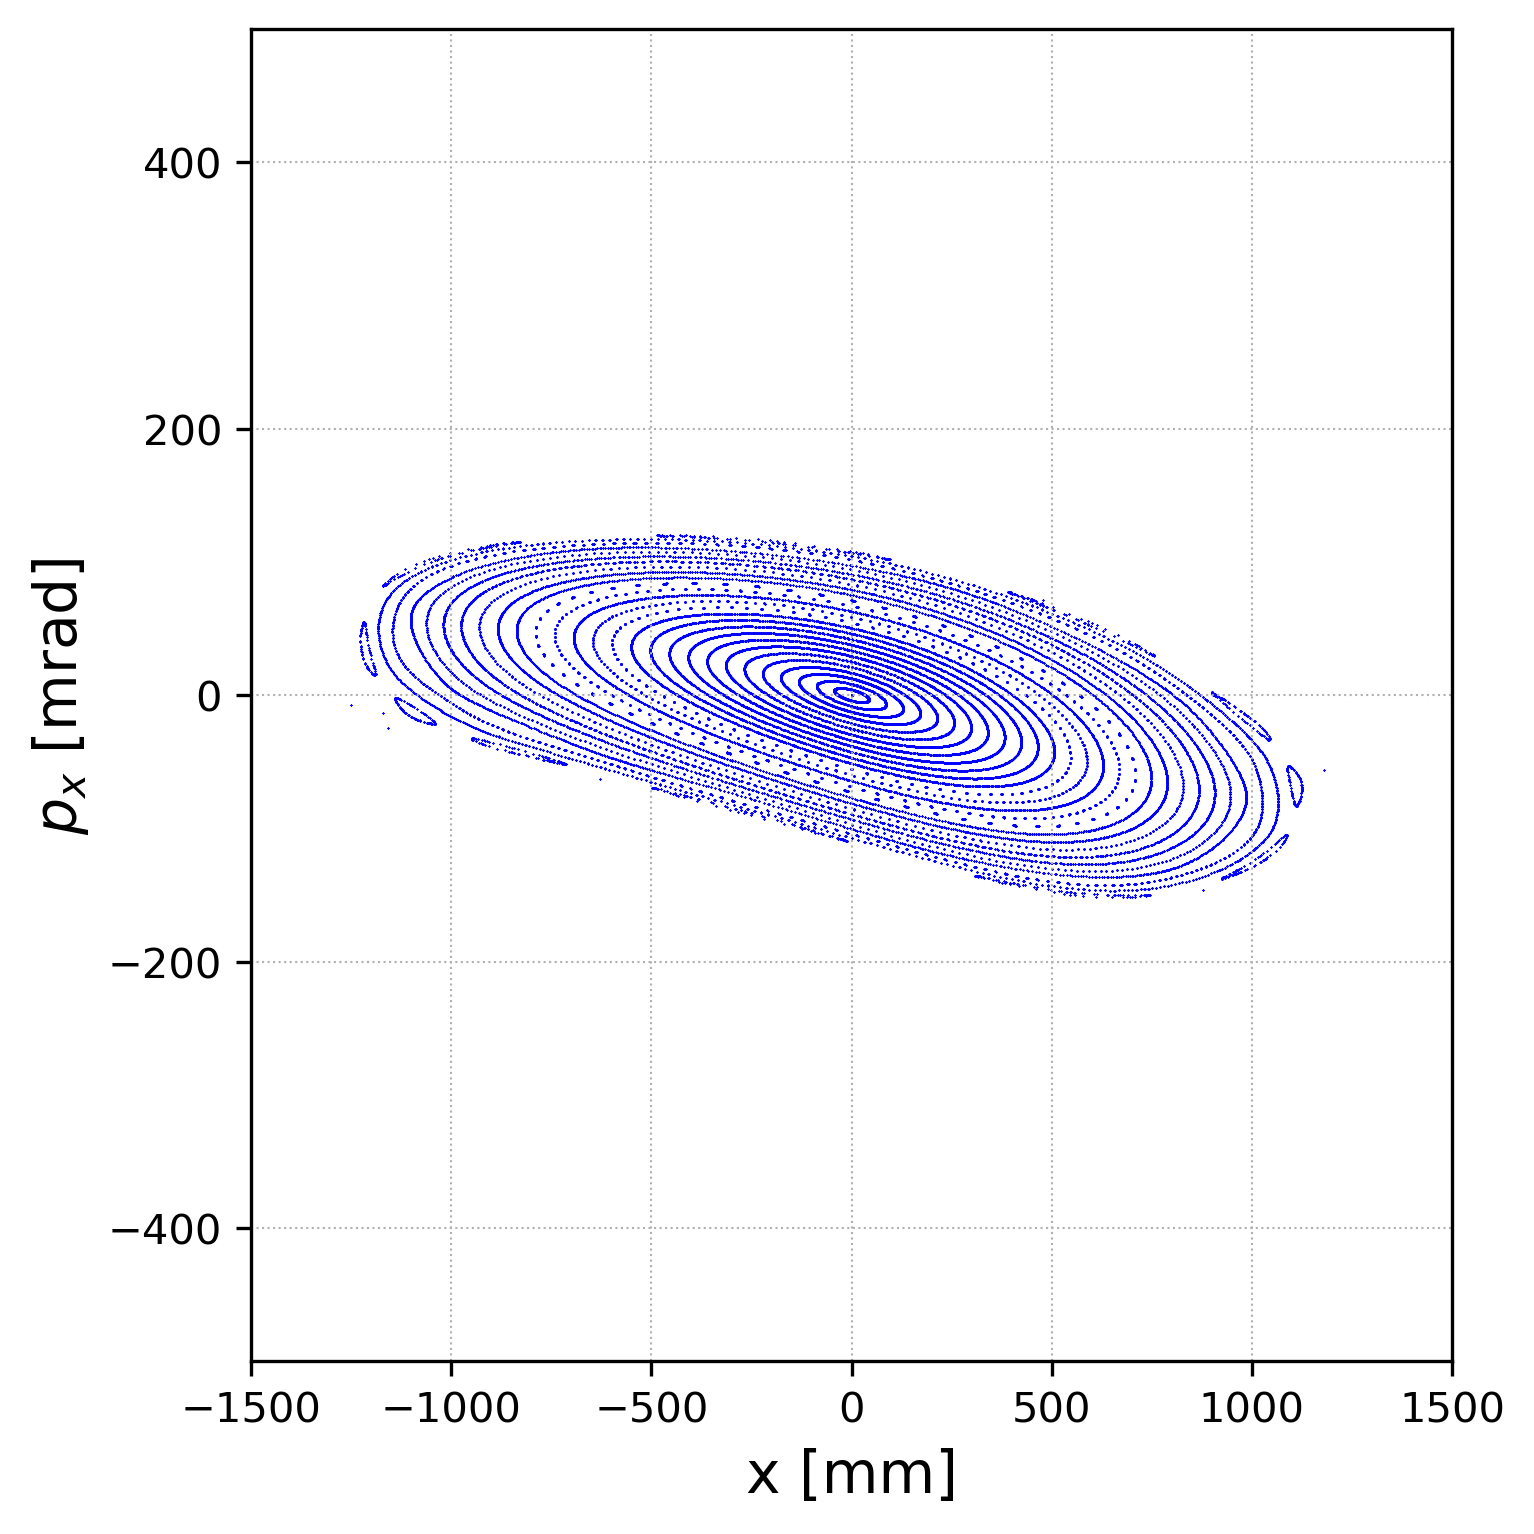

In [57]:
heights = [1]
fig1 = plt.figure(figsize=(5,5),facecolor='w', edgecolor='k',constrained_layout=True, dpi=300)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1, height_ratios=heights)
multi = 1E3

f1_ax1 = fig1.add_subplot(spec[0])  
f1_ax1.scatter(df_new['x']*multi, df_new['px']*multi, marker='x', color='b')
f1_ax1.set_xlabel('x [mm]')
f1_ax1.set_ylabel(r'$p_{x}$ [mrad]')
f1_ax1.grid(which='both', ls=':', lw=0.5)

f1_ax1.set_xlim([-1500, 1500])
f1_ax1.set_ylim([-500, 500])


savefile = plot_folder + 'Poincare_Section_H_dp_1024.png'
fig1.savefig(savefile, bbox_inches='tight');

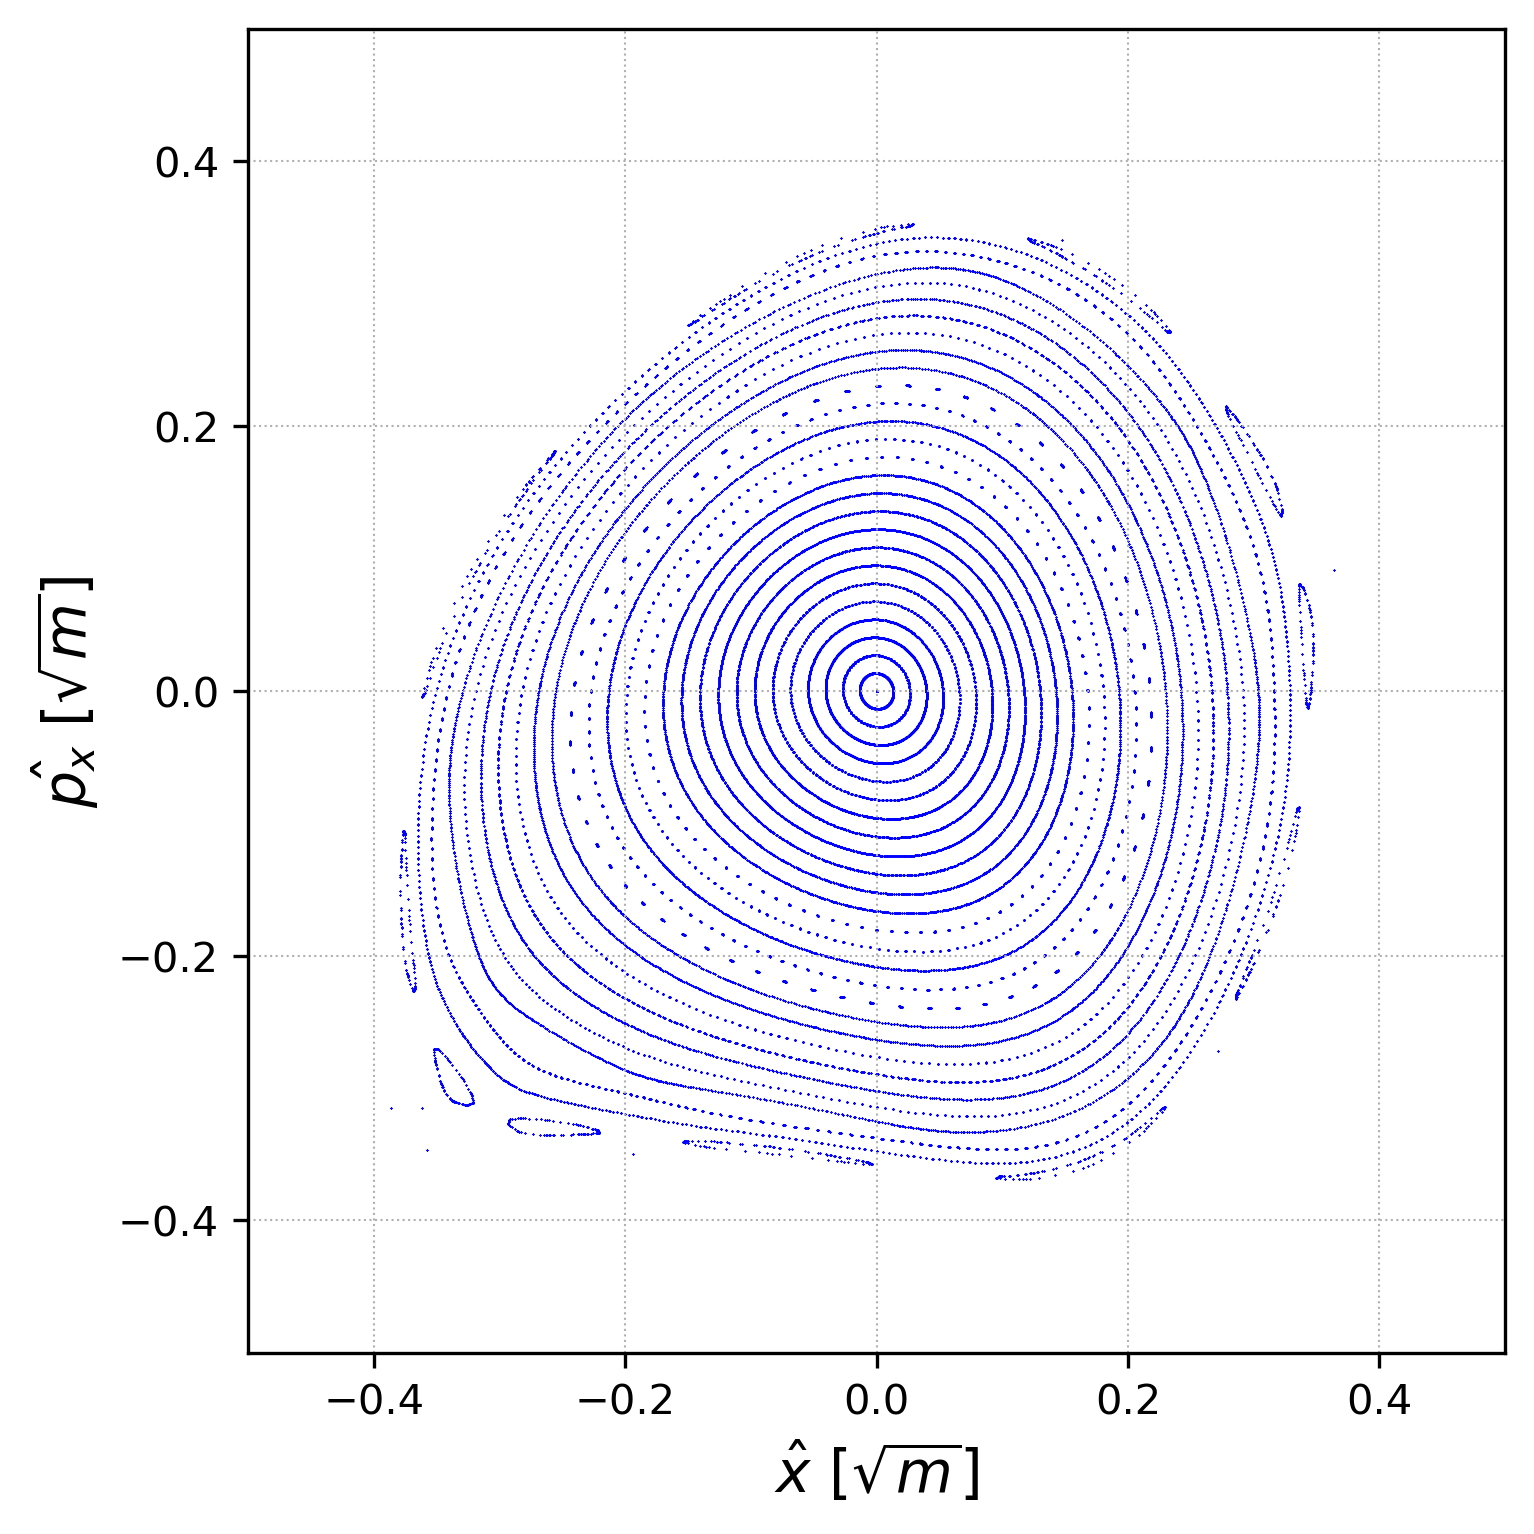

In [58]:
heights = [1]
fig1 = plt.figure(figsize=(5,5),facecolor='w', edgecolor='k',constrained_layout=True, dpi=300)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1, height_ratios=heights)
multi = 1

f1_ax1 = fig1.add_subplot(spec[0])  
f1_ax1.scatter(df_new['x_norm']*multi, df_new['px_norm']*multi, marker='x', color='b')
f1_ax1.set_xlabel(r'$\hat{x}$ [$\sqrt{m}$]')
f1_ax1.set_ylabel(r'$\hat{p_{x}}$ [$\sqrt{m}$]')
f1_ax1.grid(which='both', ls=':', lw=0.5)

f1_ax1.set_xlim([-0.5, 0.5])
f1_ax1.set_ylim([-0.5, 0.5])

savefile = plot_folder + 'Poincare_Section_H_dp_1024_norm.png'
fig1.savefig(savefile, bbox_inches='tight');

In [59]:
madx.quit()

In [60]:
break

SyntaxError: 'break' outside loop (<ipython-input-60-6aaf1f276005>, line 1)

In [ ]:
products = ('Salmon', 'Cheese', 'Butter', 'Melons', 'Ham')
prices = [5, 2, 25, 3, 1673]
product_info = {'Salmon': 5, 'Cheese': 2, 'Butter': 5, 'Melons': 3, 'Ham': 6} 
product_info['NEWPRODUCT!!!'] = 10 
print(product_info)

#### Bunch looks the same - indicates stability. Let's add a kick

In [ ]:
twiss_0[twiss_0.name.str.contains('hd')]

In [ ]:
madx.elements.sp5_r5hd1

In [ ]:
madx.elements.sp5_r5hd1.defs.kick

In [ ]:
madx.globals.defs.r5hd1_kick

In [ ]:
madx.globals.r5hd1_kick = 1E-3

In [ ]:
madx.elements.sp5_r5hd1.kick

In [ ]:
twiss_1_file = str(save_folder+'twiss_1.tfs')
twiss_1 = cpymad_madx_twiss(madx, cpymad_logfile, sequence_name, twiss_1_file)

In [ ]:
cpymad_plot_CO(madx, twiss_1, 'Synchrotron', (save_folder +'CO_1.png'))

In [ ]:
observation_list = []
track_turns = 1
cpymad_ptc_track_bunchfile(madx, cpymad_logfile, 'Synchrotron', Matched_Gaussian_4D_bunch_Filename, track_turns, observation_list, lossfiles=False)

In [ ]:
list(madx.table)

In [ ]:
df_trackone = cpymad_ptc_tracktable_to_dframe_multiple_turns('trackone', 'end', 'end')

In [ ]:
df_trackone = pandas_lowercase_all_strings(df_trackone)

In [ ]:
bunch_1_turn = ParticleBunch.from_tracked_df(df_trackone)

In [ ]:
bunch_1_turn.plot_heatmap('x', 'y', 'Plots/CO_turn_real.png', 'Matched Gaussian x-y real space')

In [ ]:
bunch_1_turn.plot_heatmap('x', 'xp', 'Plots/CO_turn_x_xp.png', 'Matched Gaussian x-xp trace space')

#### The real machine contains imperfections - many 'kicks' - the beam still circulates